In [1]:
from collections import Counter
import numpy as np
from scipy.stats import beta

from pyquantifier.distributions import MixtureCUD, ExtrinsicJointDistribution
from pyquantifier.calibration_curve import PlattScaling
from pyquantifier.data import Item, Dataset

## 1 Extrinsic data generator

### 1.1 Generate dataset

In [2]:
def generate_extrinsic_dataset(classifer_score_density_rv, w, b, num_base_size):
    # 1. Generate a dataset with `num_sample` items,
    # which pos scores follow the `classifer_score_density` distribution
    all_labels = ['pos', 'neg']
    simulated_pos_scores = classifer_score_density_rv.generate_data(num_base_size)

    calibration_curve = PlattScaling()
    calibration_curve.set_params(w, b)

    items = []
    gt_label_dict = {}
    for idx, pos_score in enumerate(simulated_pos_scores):
        item = Item(uid=idx+1, all_labels=all_labels, all_probs=[pos_score, 1-pos_score])
        items.append(item)

        calibrated_pos_score = calibration_curve.get_calibrated_prob(pos_score)[0]
        gt_label_dict[item.uid] = np.random.choice(all_labels, p=[calibrated_pos_score, 1-calibrated_pos_score])

    dataset = Dataset(items=items)
    return dataset, gt_label_dict


In [3]:
classifer_score_density_rv = MixtureCUD(components=[beta(10, 2), beta(2, 5)], weights=[2, 8])
(w, b) = (21.92, -14.61)
num_base_size = 1000000
num_bin = 10

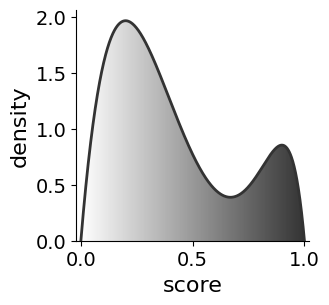

In [4]:
classifer_score_density_rv.plot()

In [5]:
extrinsic_base_dataset, extrinsic_gt_label_dict = generate_extrinsic_dataset(classifer_score_density_rv, w, b, num_base_size)

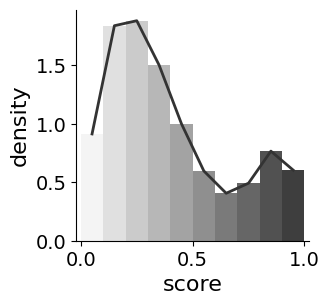

In [6]:
extrinsic_base_dataset.classifier_score_distribution = extrinsic_base_dataset.infer_classifier_score_distribution(num_bin=num_bin)
extrinsic_base_dataset.classifier_score_distribution.plot()

In [7]:
# ground truth prevalence
Counter(extrinsic_gt_label_dict.values())['pos'] / num_base_size

0.199822

### 1.2 Subsample calibration sample

In [8]:
num_sample = 1500

array([<AxesSubplot:title={'center':'Class Conditional Densities'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Label Density'}>,
       <AxesSubplot:title={'center':'Joint Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Classifier Score Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Calibration Curve'}, xlabel='$C(x)$', ylabel='$P(y=1|C(x))$'>],
      dtype=object)

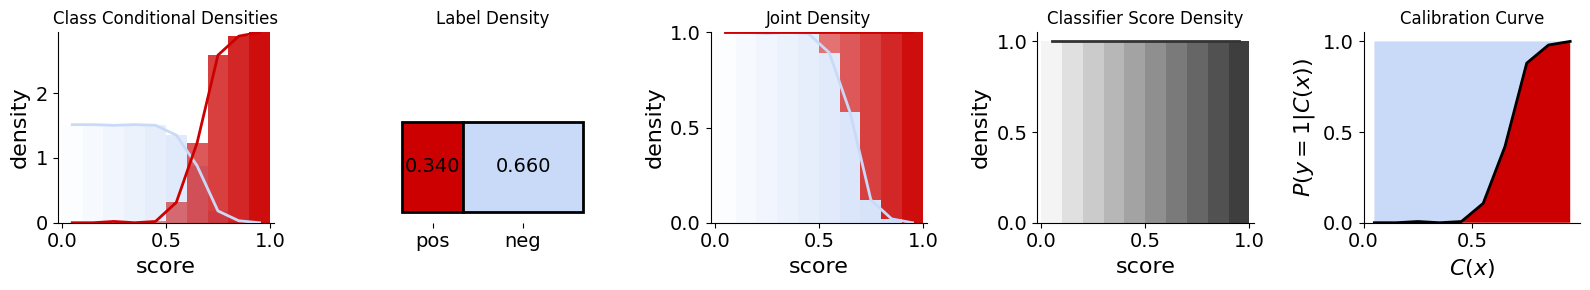

In [9]:
# 2. Select a subset of the dataset and annotate the labels
extrinsic_selected_dataset, extrinsic_selection_weights = extrinsic_base_dataset.select_sample_for_annotation(
    n=num_sample,
    strategy='uniform', 
    bins=num_bin
    )
annotated_labels = [extrinsic_gt_label_dict[uid] for uid in extrinsic_selected_dataset.df['uid'].values.astype(int)]
extrinsic_selected_dataset.annotate_sample(annotated_labels)

extrinsic_selected_dataset.profile_dataset()

### 1.3 Estimate calibration curve from calibration sample

In [10]:
# 3. Model the sampled dataset and retrieve the estimated w and b
binning_calibration_curve = extrinsic_selected_dataset.calibration_curve

True w: 21.92, True b: -14.61
Estimated w: 11.705311487617825, Estimated b: -7.712072419098894


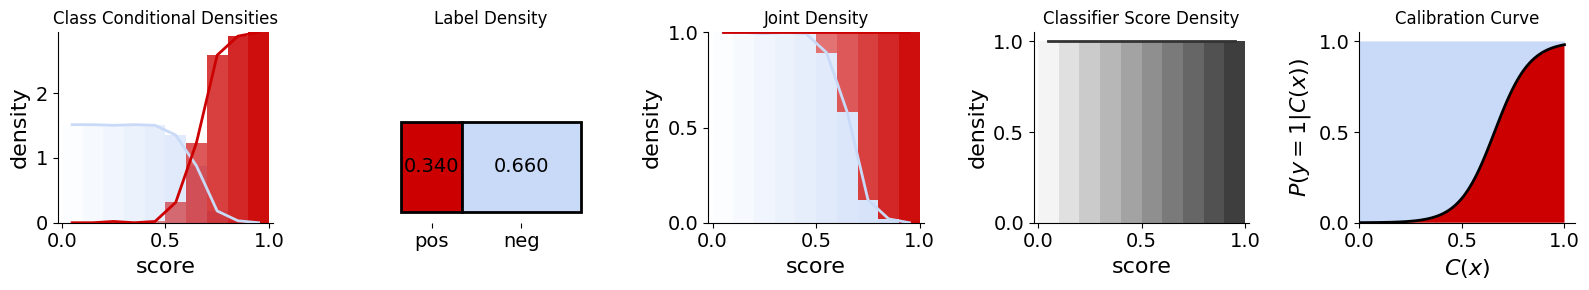

In [11]:
extrinsic_selected_dataset.update_calibration_curve(method='platt scaling')
ps_calibration_curve = extrinsic_selected_dataset.calibration_curve

extrinsic_selected_dataset.profile_dataset()

estimated_w, estimated_b = ps_calibration_curve.get_params()
estimated_w = estimated_w.item()
estimated_b = estimated_b.item()

print(f"True w: {w}, True b: {b}")
print(f"Estimated w: {estimated_w}, Estimated b: {estimated_b}")

### 1.4 Prevalence estimation

#### integrated calibration curve

In [12]:
extrinsic_base_dataset.extrinsic_estimate(calibration_curve=binning_calibration_curve)

0.20406944666666657

In [13]:
extrinsic_base_dataset.extrinsic_estimate(calibration_curve=ps_calibration_curve)

0.21024054689177935

#### Mixture model

In [14]:
# what if we don't use selection_weights
extrinsic_base_dataset.intrinsic_estimate(class_conditional_densities=extrinsic_selected_dataset.class_conditional_densities)

0.187

In [15]:
# what if we use selection_weights
base_binning_class_conditional_densities = extrinsic_selected_dataset.infer_class_conditional_densities(
    num_bin=10,
    selection_weights=extrinsic_selection_weights)

extrinsic_base_dataset.intrinsic_estimate(class_conditional_densities=base_binning_class_conditional_densities)

0.20400000000000001

In [16]:
ps_base_jd = ExtrinsicJointDistribution(['pos', 'neg'], extrinsic_base_dataset.classifier_score_distribution, ps_calibration_curve)

extrinsic_base_dataset.intrinsic_estimate(class_conditional_densities=ps_base_jd.class_conditional_densities)

0.211

In [28]:
ps_base_jd.label_distribution.get_label_prob_dict()['pos']

0.21056358347083703

## Putting everything together

In [17]:
def one_bootstrap():
    extrinsic_selected_dataset, extrinsic_selection_weights = extrinsic_base_dataset.select_sample_for_annotation(
        n=num_sample,
        strategy='uniform', 
        bins=num_bin
        )
    annotated_labels = [extrinsic_gt_label_dict[uid] for uid in extrinsic_selected_dataset.df['uid'].values.astype(int)]
    extrinsic_selected_dataset.annotate_sample(annotated_labels)
    extrinsic_selected_dataset.update_dataset_model(num_bin=num_bin)

    binning_calibration_curve = extrinsic_selected_dataset.calibration_curve
    binning_integrate_estimate = extrinsic_base_dataset.extrinsic_estimate(calibration_curve=binning_calibration_curve)

    extrinsic_selected_dataset.update_calibration_curve(method='platt scaling')
    ps_calibration_curve = extrinsic_selected_dataset.calibration_curve
    ps_integrate_estimate = extrinsic_base_dataset.extrinsic_estimate(calibration_curve=ps_calibration_curve)

    # base_binning_class_conditional_densities = extrinsic_selected_dataset.infer_class_conditional_densities(
    #     num_bin=10,
    #     selection_weights=extrinsic_selection_weights)
    binning_base_jd = ExtrinsicJointDistribution(['pos', 'neg'], extrinsic_base_dataset.classifier_score_distribution, binning_calibration_curve)
    base_binning_class_conditional_densities = binning_base_jd.class_conditional_densities
    binning_mm_estimate = extrinsic_base_dataset.intrinsic_estimate(class_conditional_densities=base_binning_class_conditional_densities)

    ps_base_jd = ExtrinsicJointDistribution(['pos', 'neg'], extrinsic_base_dataset.classifier_score_distribution, ps_calibration_curve)
    base_ps_class_conditional_densities = ps_base_jd.class_conditional_densities
    ps_mm_estimate = extrinsic_base_dataset.intrinsic_estimate(class_conditional_densities=base_ps_class_conditional_densities)

    return binning_integrate_estimate, ps_integrate_estimate, binning_mm_estimate, ps_mm_estimate

In [30]:
binning_integrate_estimate_list = []
ps_integrate_estimate_list = []
binning_mm_estimate_list = []
ps_mm_estimate_list = []

for idx in range(100):
    binning_integrate_estimate, ps_integrate_estimate, binning_mm_estimate, ps_mm_estimate = one_bootstrap()
    binning_integrate_estimate_list.append(binning_integrate_estimate)
    ps_integrate_estimate_list.append(ps_integrate_estimate)
    binning_mm_estimate_list.append(binning_mm_estimate)
    ps_mm_estimate_list.append(ps_mm_estimate)

    print(f'\niteration {idx} done')
    print(f'Binning, integrate {binning_integrate_estimate:.3f}')
    print(f'Platt, integrate {ps_integrate_estimate:.3f}')
    print(f'Binning, MM {binning_mm_estimate:.3f}')
    print(f'Platt, MM {ps_mm_estimate:.3f}')

print(f'Binning, integrate {np.mean(binning_integrate_estimate_list):.3f} +- {np.std(binning_integrate_estimate_list):.3f}')
print(f'Platt, integrate {np.mean(ps_integrate_estimate_list):.3f} +- {np.std(ps_integrate_estimate_list):.3f}')
print(f'Binning, MM, {np.mean(binning_mm_estimate_list):.3f} +- {np.std(binning_mm_estimate_list):.3f}')
print(f'Platt, MM, {np.mean(ps_mm_estimate_list):.3f} +- {np.std(ps_mm_estimate_list):.3f}')


iteration 0 done
Binning, integrate 0.197
Platt, integrate 0.201
Binning, MM 0.197
Platt, MM 0.202

iteration 1 done
Binning, integrate 0.198
Platt, integrate 0.200
Binning, MM 0.198
Platt, MM 0.200

iteration 2 done
Binning, integrate 0.201
Platt, integrate 0.207
Binning, MM 0.201
Platt, MM 0.207

iteration 3 done
Binning, integrate 0.198
Platt, integrate 0.204
Binning, MM 0.198
Platt, MM 0.205

iteration 4 done
Binning, integrate 0.200
Platt, integrate 0.203
Binning, MM 0.200
Platt, MM 0.204

iteration 5 done
Binning, integrate 0.204
Platt, integrate 0.209
Binning, MM 0.204
Platt, MM 0.209

iteration 6 done
Binning, integrate 0.202
Platt, integrate 0.205
Binning, MM 0.202
Platt, MM 0.205

iteration 7 done
Binning, integrate 0.191
Platt, integrate 0.196
Binning, MM 0.191
Platt, MM 0.196

iteration 8 done
Binning, integrate 0.197
Platt, integrate 0.203
Binning, MM 0.198
Platt, MM 0.204

iteration 9 done
Binning, integrate 0.199
Platt, integrate 0.203
Binning, MM 0.199
Platt, MM 0.204


[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[0.         0.         0.0614709  0.         0.03266894 0.31192519
 0.83541266 2.12197567 3.67941606 2.95713057]
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[1.14751217 2.3104277  2.34832758 1.8866847  1.24802756 0.66978909
 0.29578937 0.07418939 0.01925243 0.        ]


0.20400000000000001

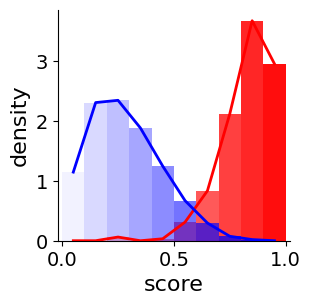

In [19]:
base_binning_class_conditional_densities = extrinsic_selected_dataset.infer_class_conditional_densities(
    num_bin=10,
    selection_weights=extrinsic_selection_weights)
# binning_base_jd = ExtrinsicJointDistribution(['pos', 'neg'], extrinsic_base_dataset.classifier_score_distribution, binning_calibration_curve)
# base_binning_class_conditional_densities = binning_base_jd.class_conditional_densities
binning_mm_estimate = extrinsic_base_dataset.intrinsic_estimate(class_conditional_densities=base_binning_class_conditional_densities)

ax = base_binning_class_conditional_densities['pos'].plot(return_ax=True, color='red')
base_binning_class_conditional_densities['neg'].plot(ax=ax, color='blue')

print(base_binning_class_conditional_densities['pos'].x_axis)
print(base_binning_class_conditional_densities['pos'].y_axis)
print(base_binning_class_conditional_densities['neg'].x_axis)
print(base_binning_class_conditional_densities['neg'].y_axis)

binning_mm_estimate

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[0.         0.         0.0614709  0.         0.03266894 0.31192519
 0.83541266 2.12197567 3.67941606 2.95713057]
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[1.14751217 2.3104277  2.34832758 1.8866847  1.24802756 0.66978909
 0.29578937 0.07418939 0.01925243 0.        ]


0.20400000000000001

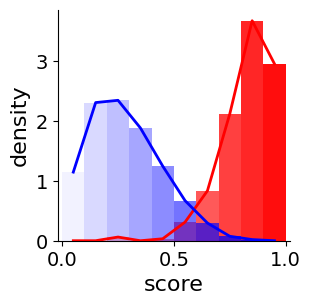

In [20]:
# base_binning_class_conditional_densities = extrinsic_selected_dataset.infer_class_conditional_densities(
#     num_bin=10,
#     selection_weights=extrinsic_selection_weights)
binning_base_jd = ExtrinsicJointDistribution(['pos', 'neg'], extrinsic_base_dataset.classifier_score_distribution, binning_calibration_curve)
base_binning_class_conditional_densities = binning_base_jd.class_conditional_densities
binning_mm_estimate = extrinsic_base_dataset.intrinsic_estimate(class_conditional_densities=base_binning_class_conditional_densities)

ax = base_binning_class_conditional_densities['pos'].plot(return_ax=True, color='red')
base_binning_class_conditional_densities['neg'].plot(ax=ax, color='blue')

print(base_binning_class_conditional_densities['pos'].x_axis)
print(base_binning_class_conditional_densities['pos'].y_axis)
print(base_binning_class_conditional_densities['neg'].x_axis)
print(base_binning_class_conditional_densities['neg'].y_axis)

binning_mm_estimate